# USPEX prism point-source reduction example

Last updated 23 May 2025

This notebook demonstrates the reduction of a USPEX prism point-source data using the test data provided with the code in tests/test_data/raw/wuspex-prism

## Steps:
* setup instrument parameters
* reduce calibration data
* extract science point source
* extract telluric standard point source
* combine individual science spectra into one spectrum
* combine individual telluric spectra into one spectrum
* telluric calibration science spectrum


In [1]:
# import package and check
import pyspextool as ps
import os, sys
import numpy as np
import matplotlib.pyplot as plt

help(ps)

Help on package pyspextool:

NAME
    pyspextool

DESCRIPTION
    PySpexTool is a package intended to contain core functionality and some
    common tools needed for performing reduction for SpeX instrument in
    Python.

PACKAGE CONTENTS
    batch (package)
    combine (package)
    config
    extract (package)
    fit (package)
    io (package)
    plot (package)
    pyspextoolerror
    setup_utils
    telluric (package)
    utils (package)

FILE
    /Users/chsu/projects/pyspextool/src/pyspextool/__init__.py




# Setup

While users should be able to run the Jupyter notebook tutorials without changing the output paths, users are encouraged to move the data folder and rename the output paths. Users can define the output paths, including the `cal`, `proc`, and `qa` in the next cell to where users would like to save their data.

In [2]:
# what instrument and mode we are using
instrument = 'uspex'
inst_mode = 'prism'

file_base = ps.__file__.split('/src/')[0]
topbase = os.getenv("HOME")

# point to test data folder for USPEX prism data
raw = file_base + '/tests/test_data/raw/' + instrument + '-' + inst_mode + '/data/'
cal = topbase + '/test_pyspextool/test_data/processed/' + instrument + '-' + inst_mode + '/cals/' # Users can change this
proc = topbase + '/test_pyspextool/test_data/processed/' + instrument + '-' + inst_mode + '/proc/' # Users can change this
qa = topbase + '/test_pyspextool/test_data/processed/' + instrument + '-' + inst_mode + '/qa/' # Users can change this
src_prefix = 'sbd.2022B046.221019.spc.'
flat_prefix = 'sbd.2022B046.221019.flat.'
arc_prefix = 'sbd.2022B046.221019.arc.'

# Input files and standard name
obj_name = 'J2010-1707'
std_name = 'HD193689'
files = '1-2'
std_files = '7-8'
flat_files = '15-19'
wave_files = '20'

# extraction details
mode = 'A-B'
naps = 1 if mode == 'A' else 2
aperture_signs = None

aperture_find = ['auto',2]
include_orders = None
correct_bias = True
correct_linearity=True

flatfield_file = 'flat%s.fits'%flat_files
wavecal_file = 'wavecal%s.fits'%wave_files

flat_field = True

fix_badpixels = True
bg_annulus = [2,2.5]
psf_radius = None
aperture = 1.5

verbose = True
qa_show = True # You can turn this off when running a bulk reduction
qa_write = True # Write QA plots
qa_extension = '.pdf' # file types for QA plots
qa_showblock=True
write_model_spectra = False # default

# create output folders if they do not exist
if not os.path.exists(cal):
	os.makedirs(cal)
if not os.path.exists(proc):
	os.makedirs(proc)
if not os.path.exists(qa):
	os.makedirs(qa)



In [3]:
# Create output name

output_prefix = mode
if correct_bias is True:  output_prefix += '_bc'
if correct_linearity is True:  output_prefix += '_lc'
if flat_field is True:  output_prefix += '_flat'
if flat_field is not None:  output_prefix += '_wc'
if fix_badpixels is True:  output_prefix += '_fxbdpx'

output_prefix += '-'

In [4]:
# set up instrument
ps.pyspextool_setup(instrument, raw_path=raw, qa_path=qa, cal_path=cal,
                    proc_path=proc, verbose=verbose, qa_write=qa_write,
                    qa_show=qa_show, qa_showblock=qa_showblock)

INFO:  pySpextool Setup
----------------------

INFO:  Verbose set to True. 
 Logging level set to 20
INFO:  Instrument set to uspex
INFO:  Paths set
INFO:  QA settings set


## Calibrations

INFO:  Generating Flat Field
---------------------------

INFO:  Loading the images.
INFO:  Loading images(s) sbd.2022B046.221019.flat.00015.a.fits, sbd.2022B046.221019.flat.00016.a.fits, sbd.2022B046.221019.flat.00017.a.fits, sbd.2022B046.221019.flat.00018.a.fits, sbd.2022B046.221019.flat.00019.a.fits correcting bias drift, and not correcting for non-linearity.


100% |**********************************************************************|


INFO:  Scaling the images.
INFO:  Medianing the images.
INFO:  Locating the orders.


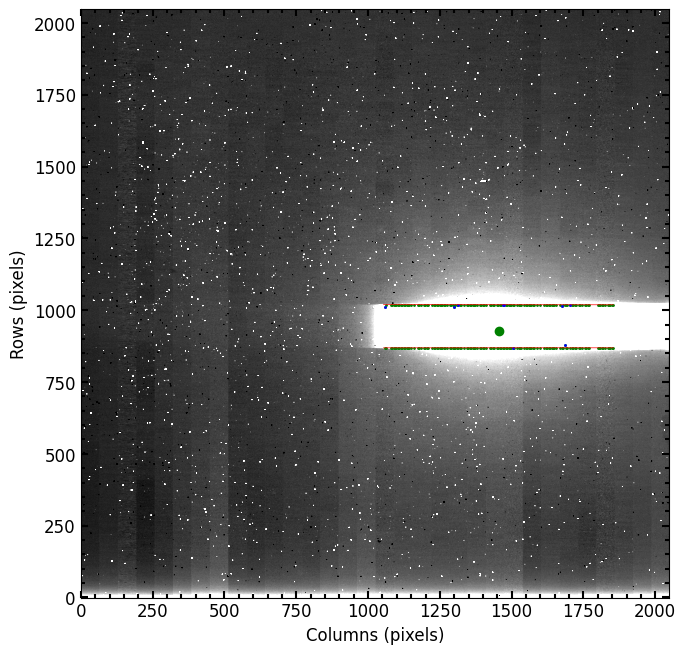

INFO:  Normalizing the median flat.


100% |**********************************************************************|
100% |**********************************************************************|


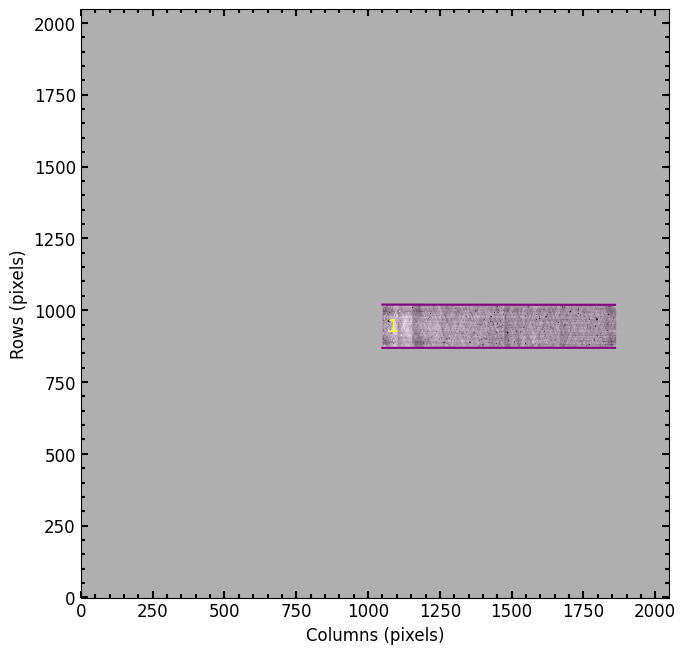

INFO:  Flat field file flat15-19.fits written to disk.

INFO:  Generating Wavelength Solution
------------------------------------

INFO:  Creating the arc image.


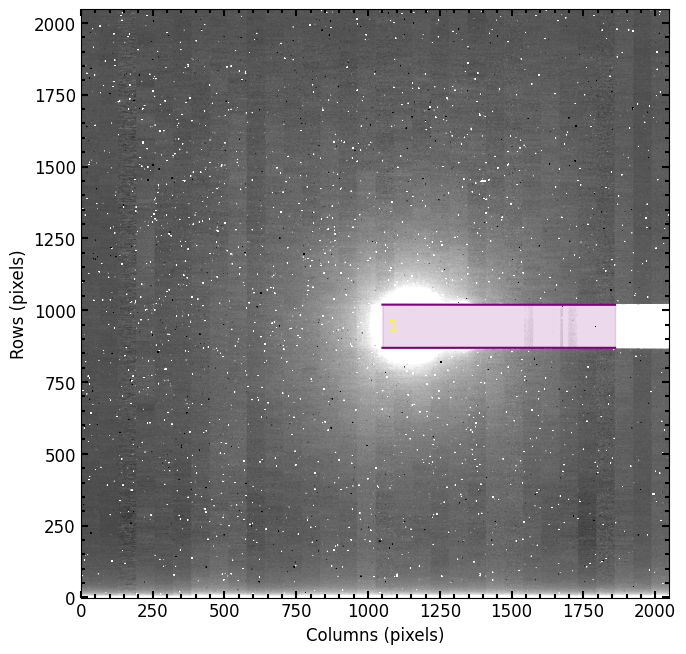

INFO:  Sum extracting 1 aperture in 1 orders (without background subtraction).


100% |**********************************************************************|


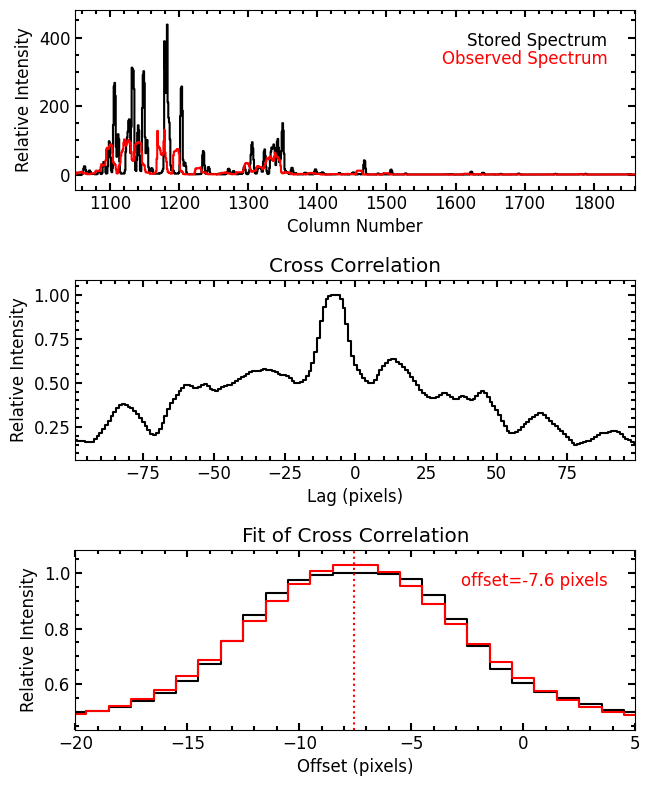

INFO:  Using stored wavelength solution.
INFO:  Writing wavecal to disk.
INFO:  Wavecal file wavecal20.fits written to disk.



In [5]:
# conduct calibrations
ps.extract.make_flat([flat_prefix,flat_files],flatfield_file.rstrip('.fits'))

ps.extract.make_wavecal([arc_prefix,wave_files], flatfield_file, wavecal_file.rstrip('.fits'))

## Extract telluric standard files

INFO:  Setting reduction mode to A-B.
INFO:  Loading the flat file flat15-19.fits.
INFO:  Loading the wavecal file wavecal20.fits.
INFO:  Loading the atmospheric tranmission at R=100.
INFO:  Loading images(s) sbd.2022B046.221019.spc.00007.a.fits, sbd.2022B046.221019.spc.00008.b.fits correcting bias drift, and correcting for non-linearity.


100% |**********************************************************************|


INFO:  Flat fielding the image.
INFO:  Rectifying the orders.


100% |**********************************************************************|


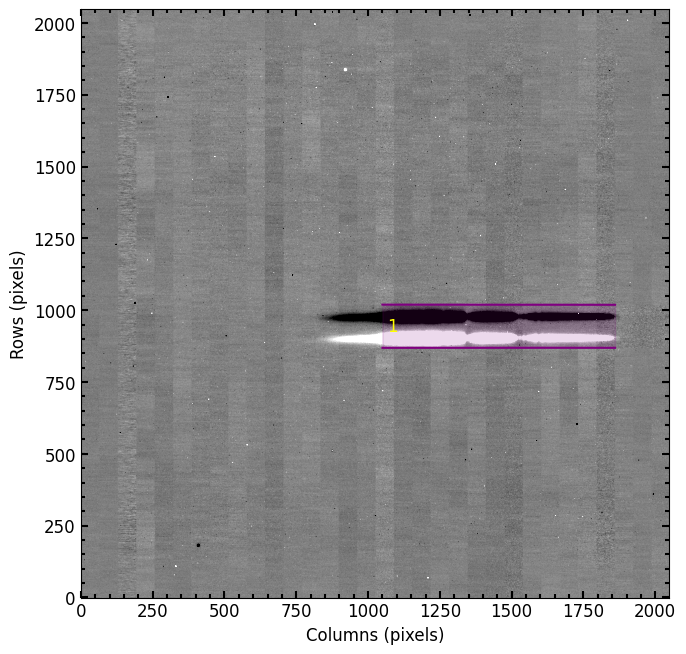

INFO:  Creating the 1D spatial profiles.


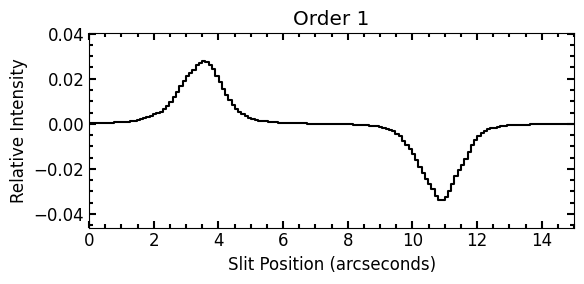

INFO:  Locating the apertures.
INFO:  Aperture signs are (+, -).


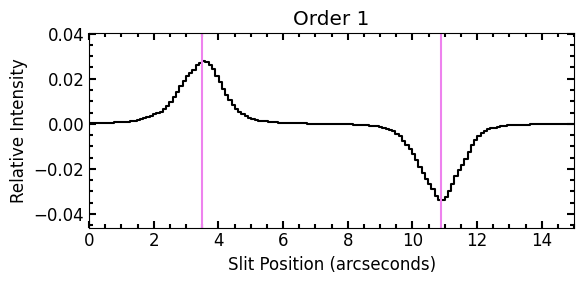

INFO:  Tracing apertures.


100% |**********************************************************************|


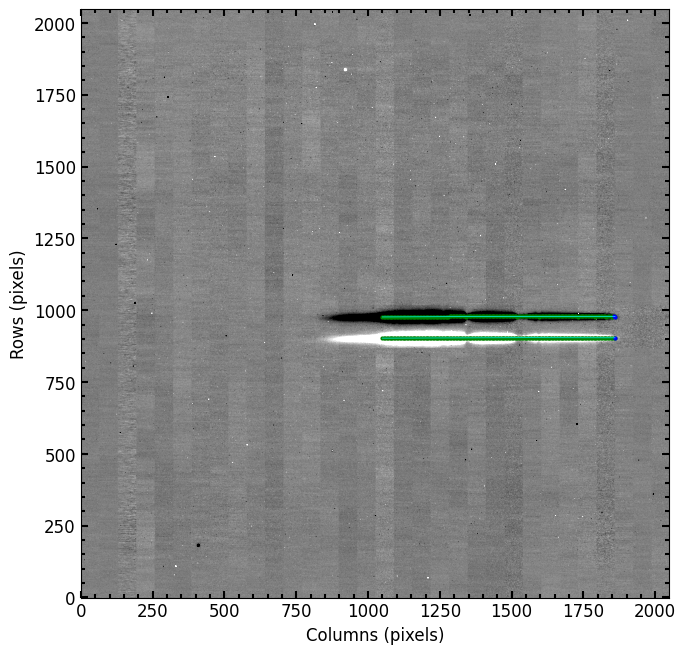

INFO:  Defining aperture parameters.


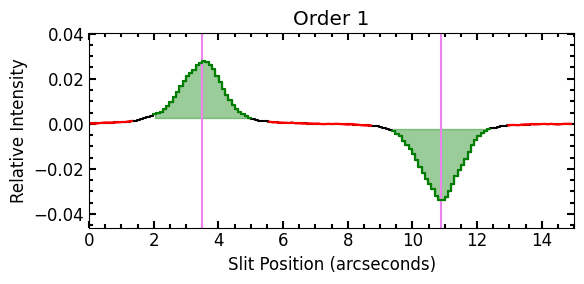

INFO:  Sum extracting 2 apertures in 1 orders (with background subtraction).
INFO:  Wrote file(s) A-B_bc_lc_flat_wc_fxbdpx-00007.fits, A-B_bc_lc_flat_wc_fxbdpx-00008.fits to proc/.



100% |**********************************************************************|


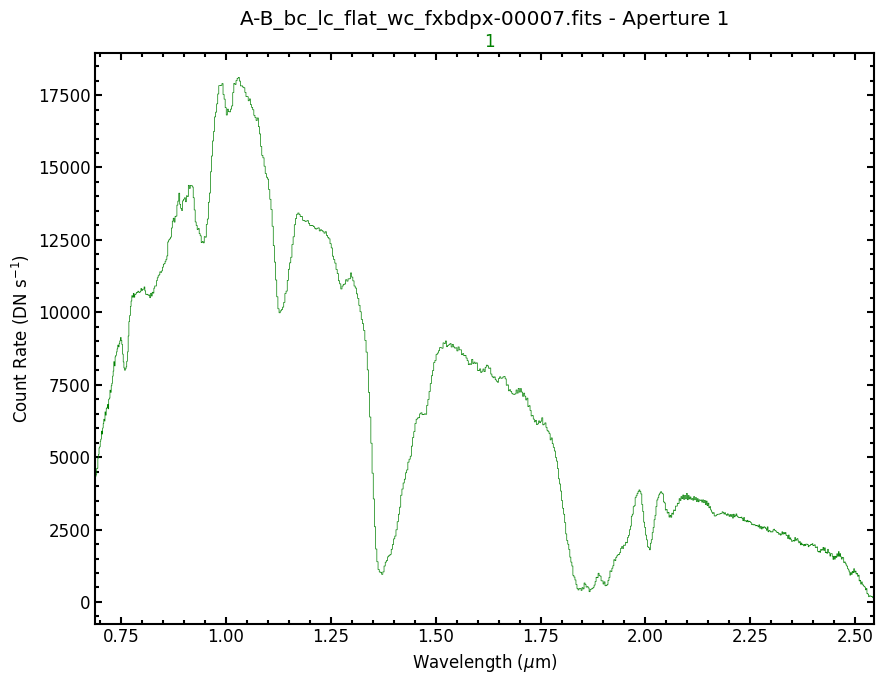

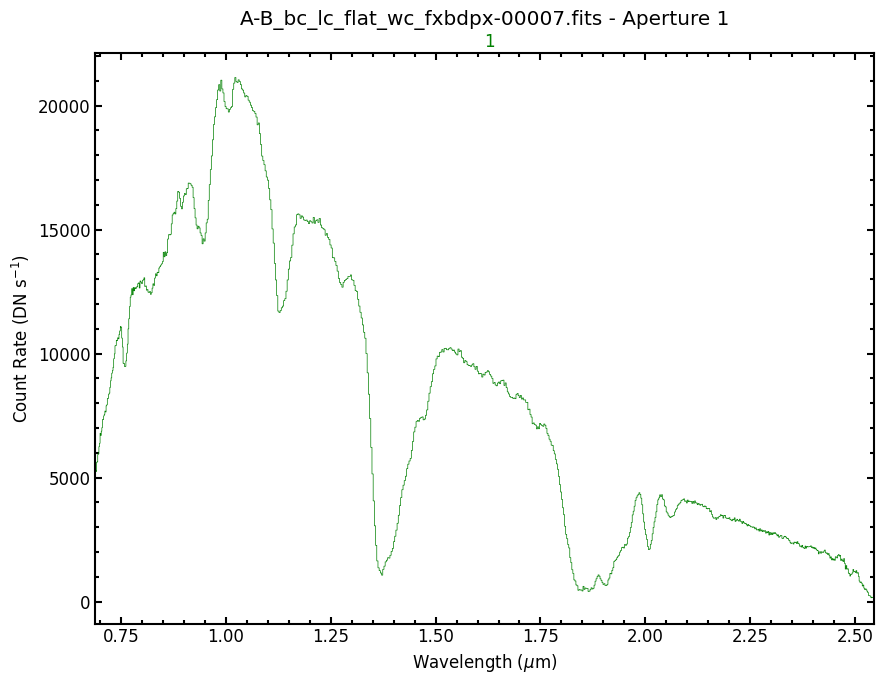

In [6]:
# Extract standard 

ps.extract.extract(mode,
                   [src_prefix,std_files],
                   flatfield_file,
                   wavecal_file,
                   aperture_find,
                   aperture,
                   flat_field=flat_field,
                   linearity_correction=correct_linearity,
                   output_prefix=output_prefix,
                   write_rectified_orders=False,
                   aperture_signs=aperture_signs,
                   include_orders=include_orders,
                   bg_annulus=bg_annulus,
                   fix_badpixels=fix_badpixels,
                   psf_radius=psf_radius,
                   detector_info={'correct_bias':correct_bias})

## Extract science files

INFO:  Setting reduction mode to A-B.
INFO:  Loading the flat file flat15-19.fits.
INFO:  Loading the wavecal file wavecal20.fits.
INFO:  Loading the atmospheric tranmission at R=100.
INFO:  Loading images(s) sbd.2022B046.221019.spc.00001.a.fits, sbd.2022B046.221019.spc.00002.b.fits correcting bias drift, and correcting for non-linearity.


100% |**********************************************************************|


INFO:  Flat fielding the image.
INFO:  Rectifying the orders.


100% |**********************************************************************|


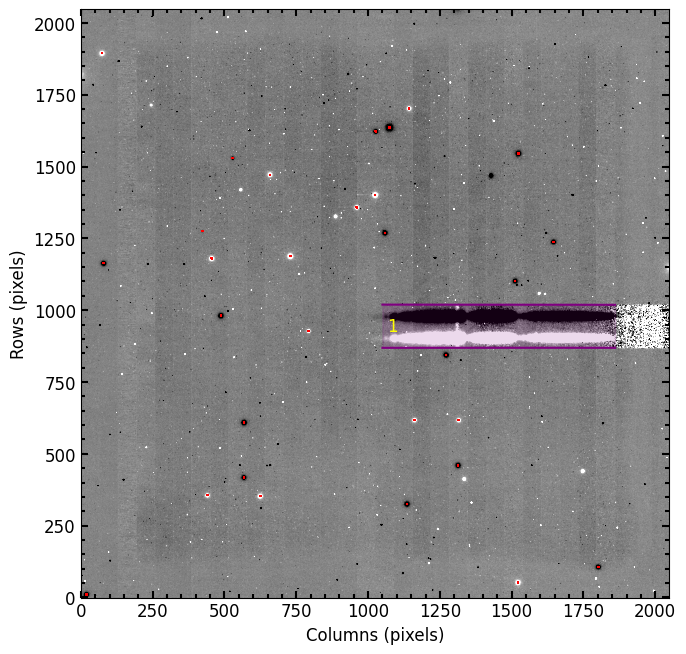

INFO:  Creating the 1D spatial profiles.


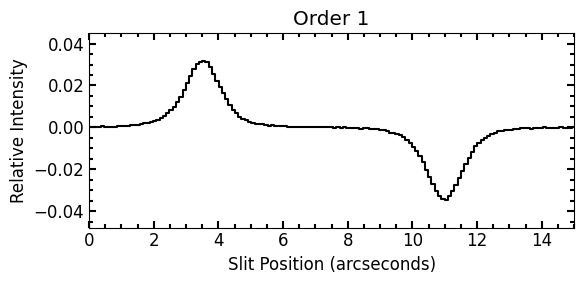

INFO:  Locating the apertures.
INFO:  Aperture signs are (+, -).


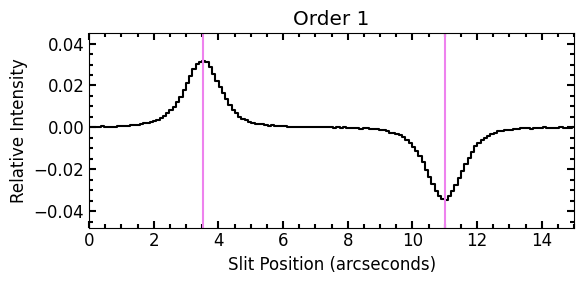

INFO:  Tracing apertures.


100% |**********************************************************************|


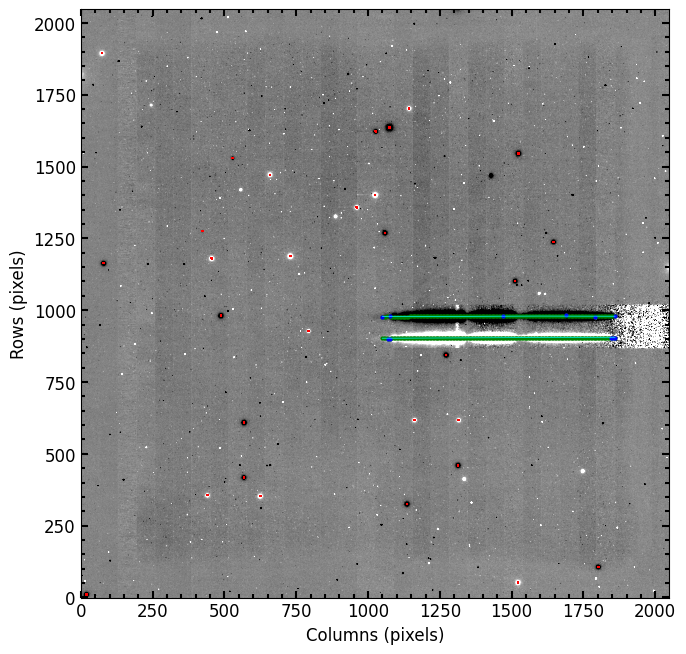

INFO:  Defining aperture parameters.


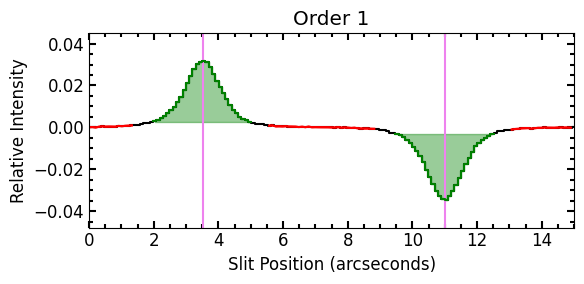

INFO:  Sum extracting 2 apertures in 1 orders (with background subtraction).
INFO:  Wrote file(s) A-B_bc_lc_flat_wc_fxbdpx-00001.fits, A-B_bc_lc_flat_wc_fxbdpx-00002.fits to proc/.



100% |**********************************************************************|


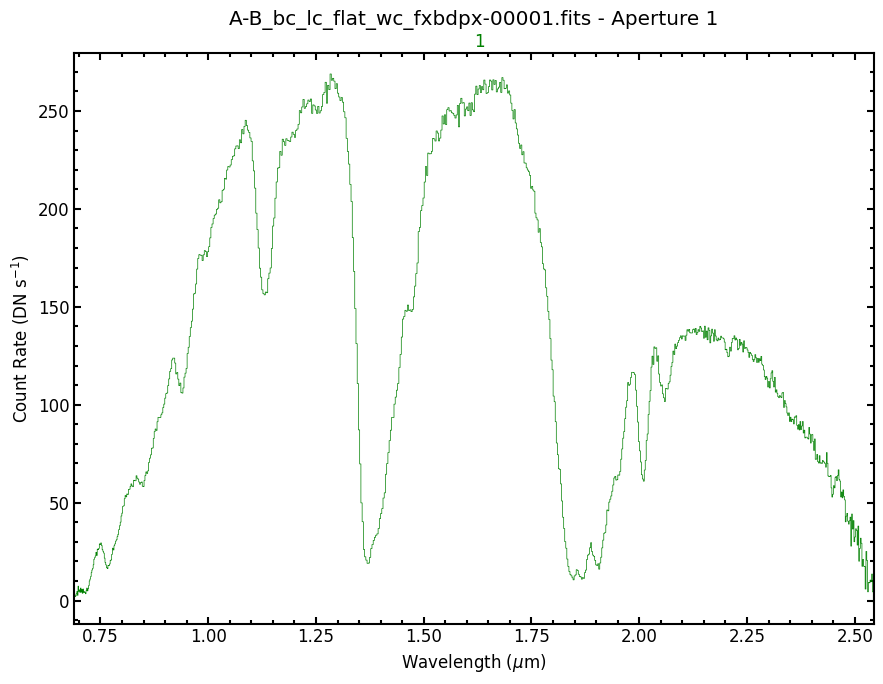

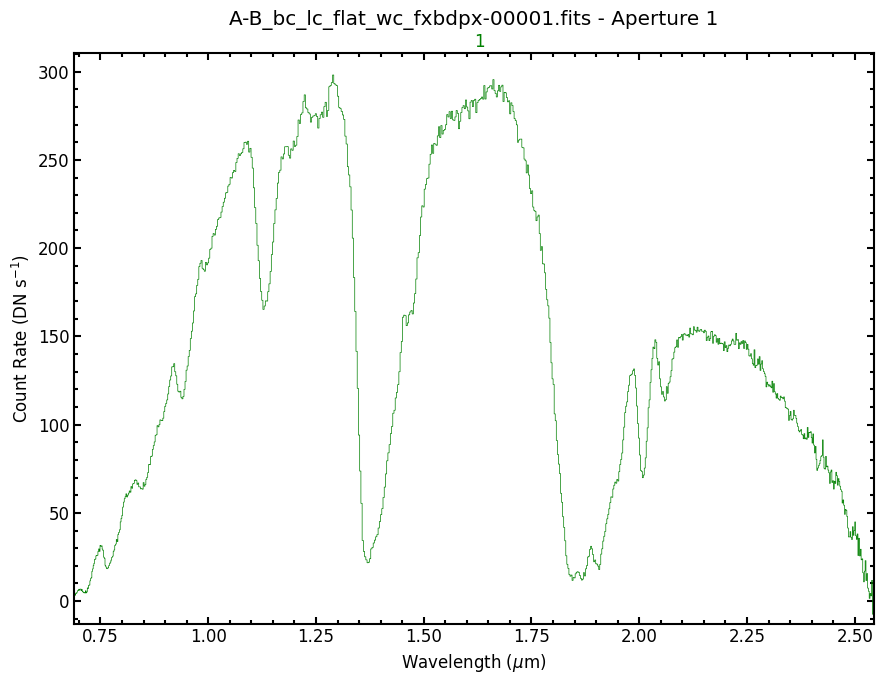

In [7]:
# Extract science target

ps.extract.extract(mode,
                   [src_prefix,files],
                   flatfield_file,
                   wavecal_file,
                   aperture_find,
                   aperture,
                   flat_field=flat_field,
                   linearity_correction=correct_linearity,
                   output_prefix=output_prefix,
                   write_rectified_orders=False,
                   aperture_signs=aperture_signs,
                   include_orders=include_orders,
                   bg_annulus=bg_annulus,
                   fix_badpixels=fix_badpixels,
                   psf_radius=psf_radius,
                   detector_info={'correct_bias':correct_bias})


## Combine standard and science spectra

INFO:  Combining Spectra
-----------------------

INFO:  Loading the spectra.


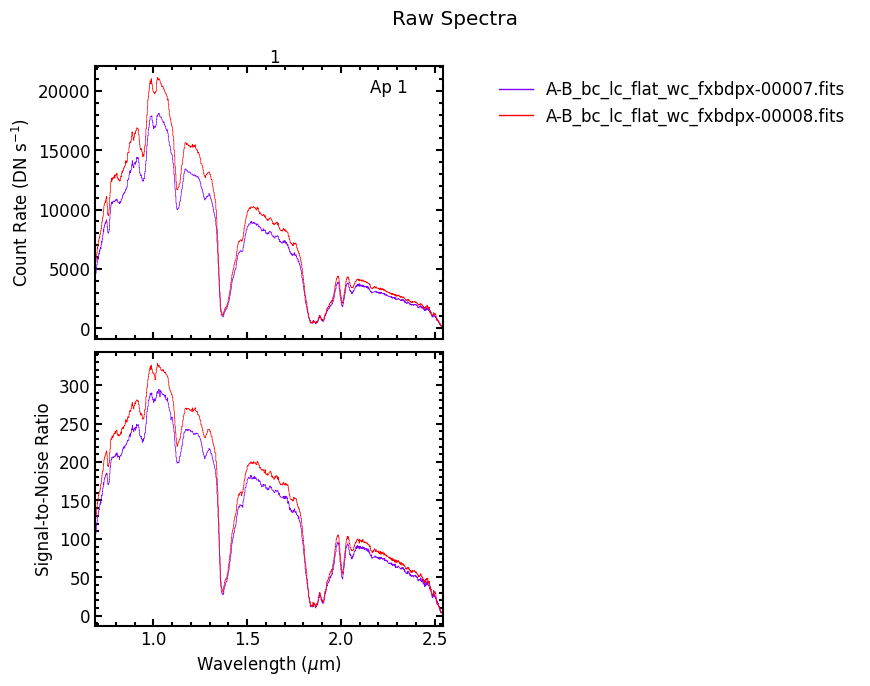

INFO:  Scaling the spectra to a common intensity level.
INFO:  Using order 1 to determine scale factors.


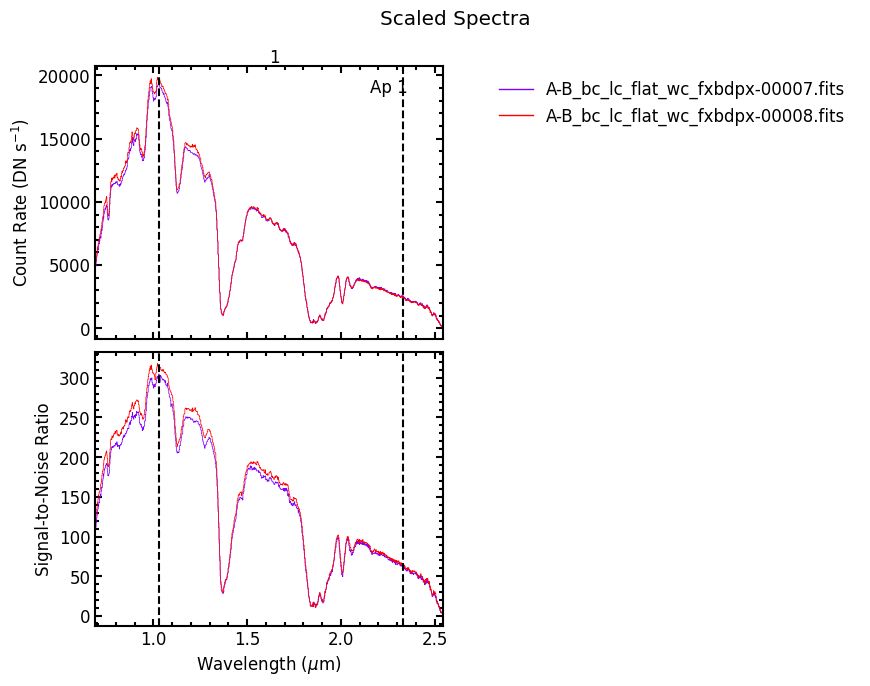

INFO:  Combining the spectra using a robust weighted mean.
INFO:  Wrote file HD193689.fits to proc/.


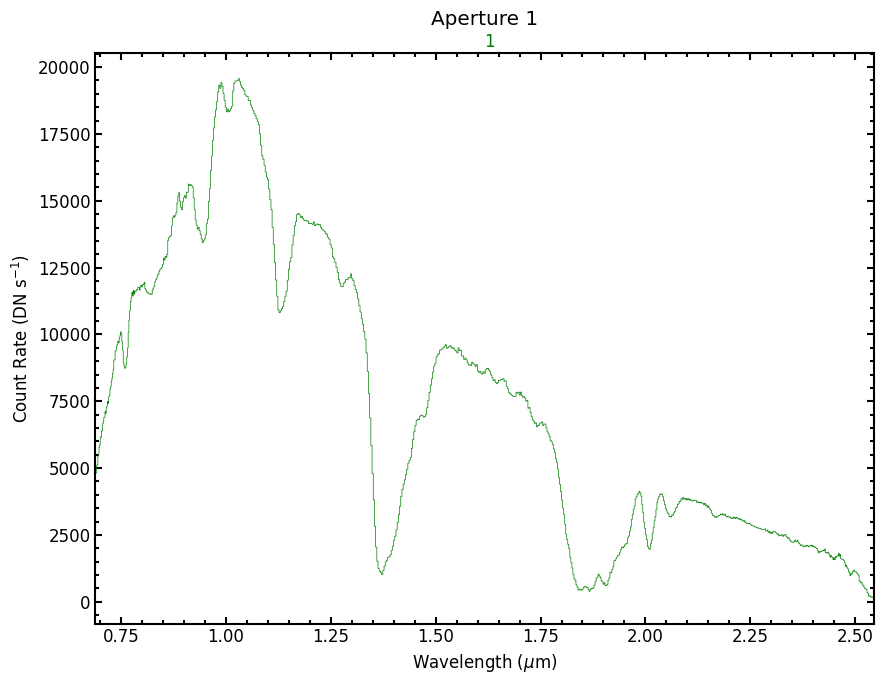

In [8]:
# Combine the standard
ps.combine.combine(['A-B_bc_lc_flat_wc_fxbdpx-',std_files],std_name)

INFO:  Combining Spectra
-----------------------

INFO:  Loading the spectra.


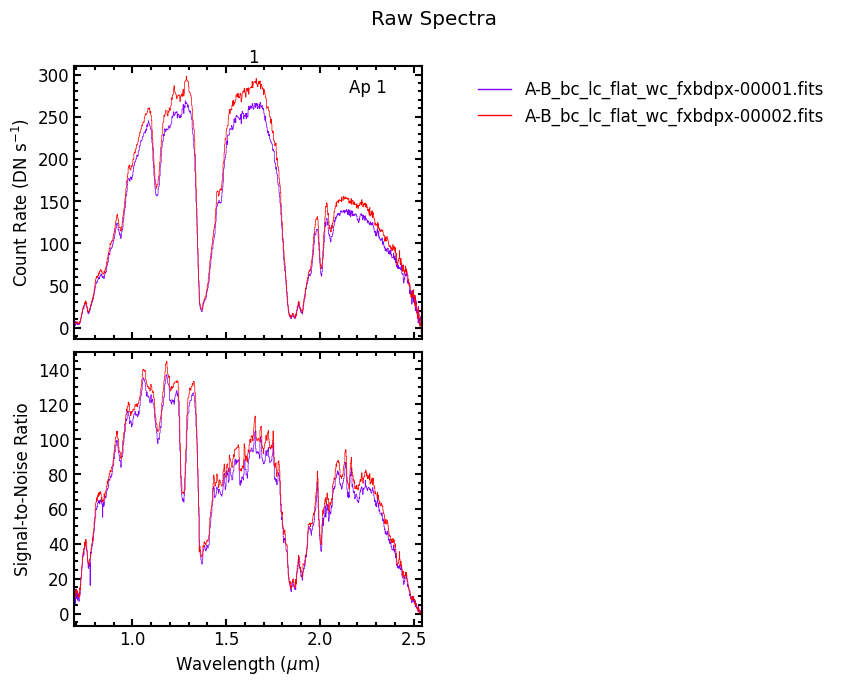

INFO:  Scaling the spectra to a common intensity level.
INFO:  Using order 1 to determine scale factors.


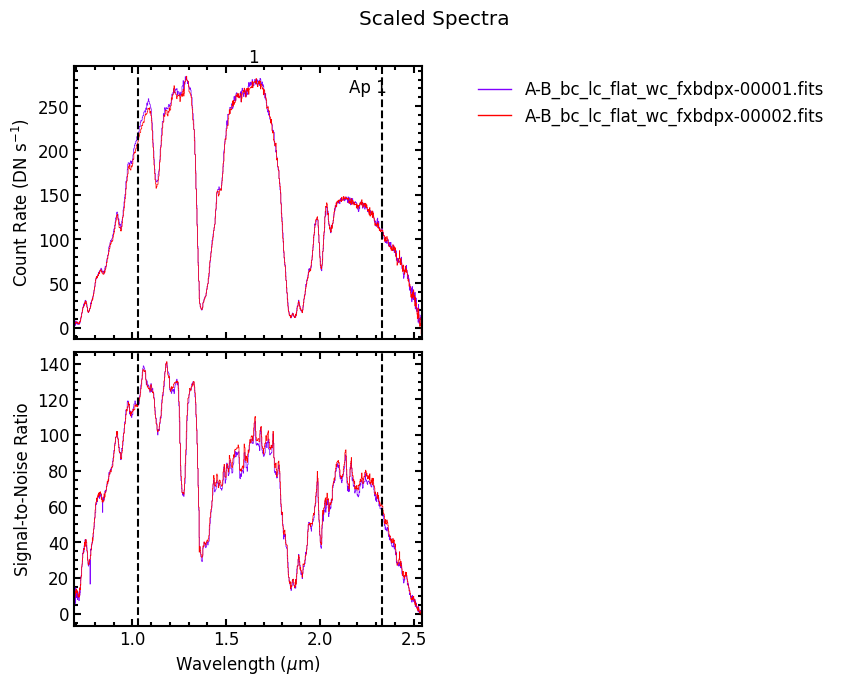

INFO:  Combining the spectra using a robust weighted mean.
INFO:  Wrote file J2010-1707.fits to proc/.


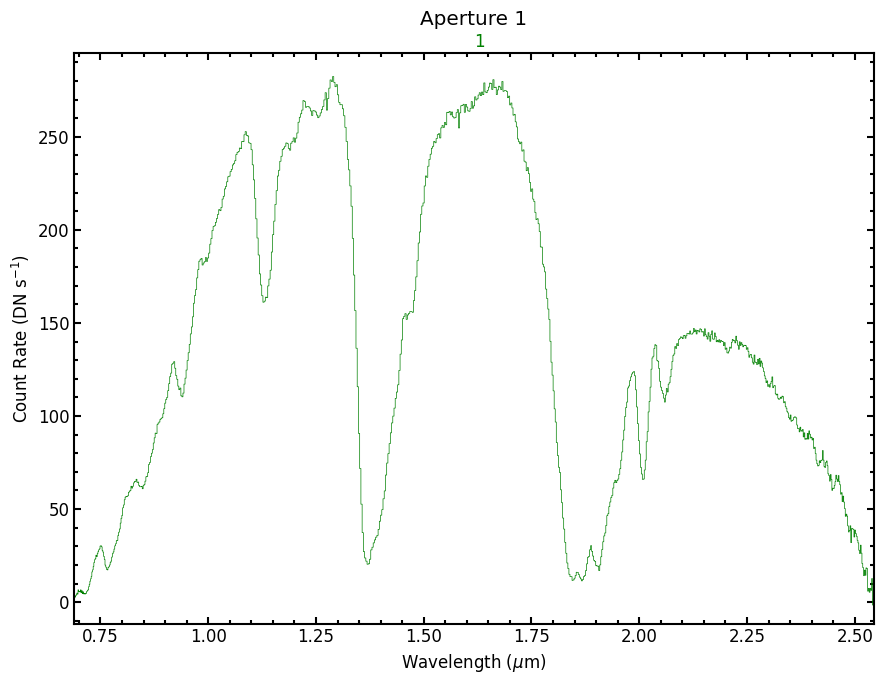

In [9]:
# Combine the science target
ps.combine.combine(['A-B_bc_lc_flat_wc_fxbdpx-',files],obj_name)

# Perform telluric correction with science target and standard

INFO:  Telluric Correction
--------------------------

INFO:  Loading the object spectrum.
INFO:  Loading the standard spectrum.
INFO:  Querying SIMBAD for standard star HD193689 information.
INFO:  Loading the Vega model.
INFO:  Telluric method = ip
INFO:  Generating the kernels.
INFO:  Adjusting the EWs of standard star absorption lines.
INFO:  Making telluric correction spectra.
INFO:  Shifting spectra to minimize telluric noise.


/Users/chsu/test_pyspextool/test_data/processed/uspex-prism/proc/HD193689.fits


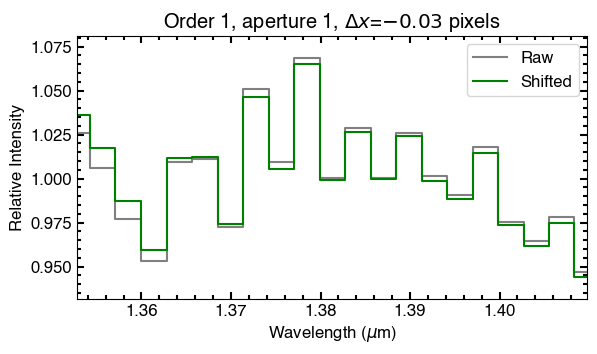

INFO:  Correcting spectra.
INFO:  Wrote file calspec1-2_telluric.fits to proc/.
INFO:  Wrote file calspec1-2.fits to proc/.


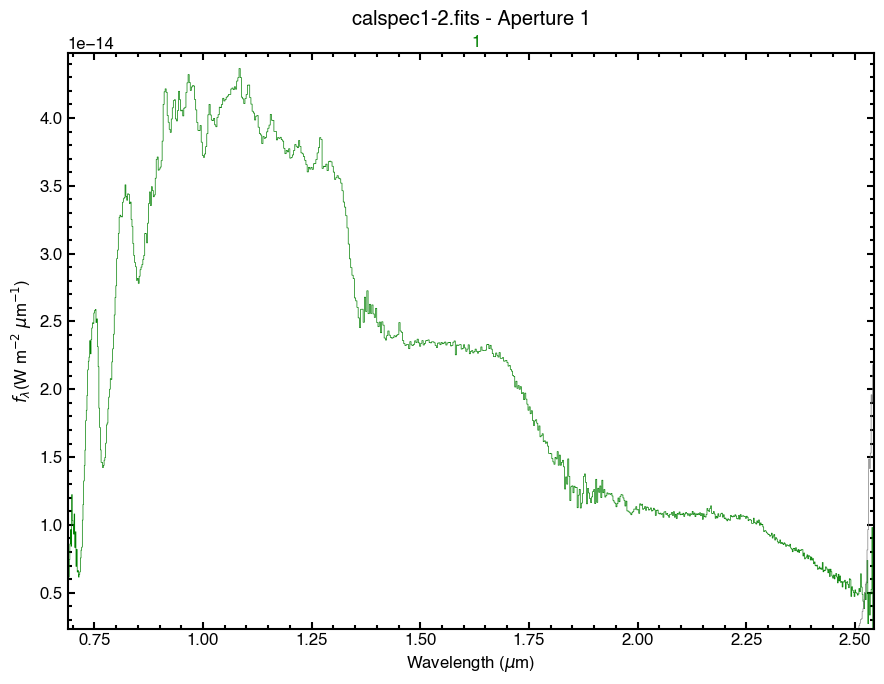

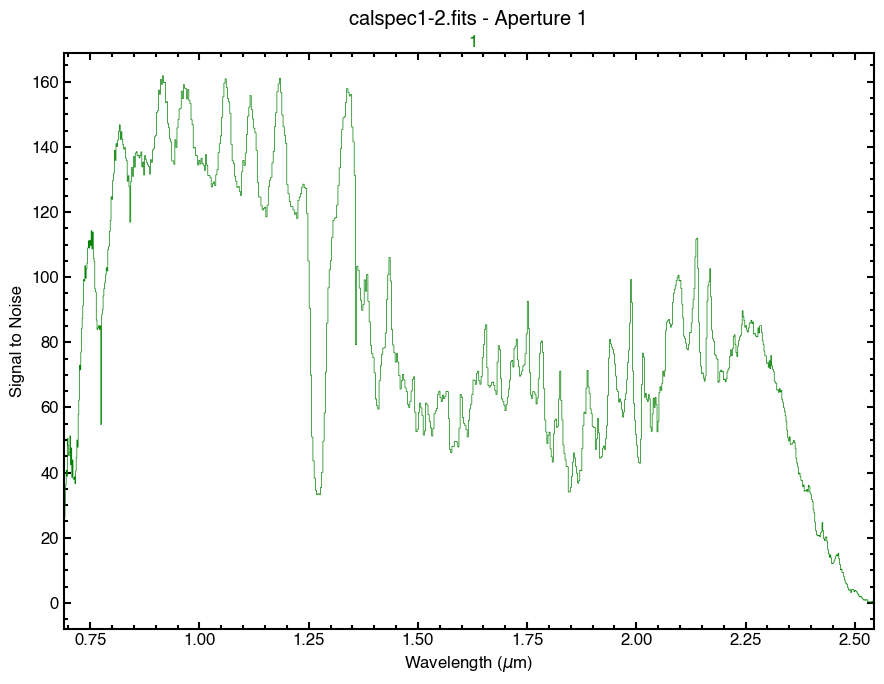

In [10]:
# Perform telluric correction with science target and standard
ps.telluric.telluric(obj_name+'.fits',std_name+'.fits',std_name,'calspec'+files, write_model_spectra=write_model_spectra)

# Checking your outputs

You should find several output files in your cals and proc folders that allow you to visualize the calibrations and extractions. In addition, you can read in the spectrum and visualize it with plot_spectra.py


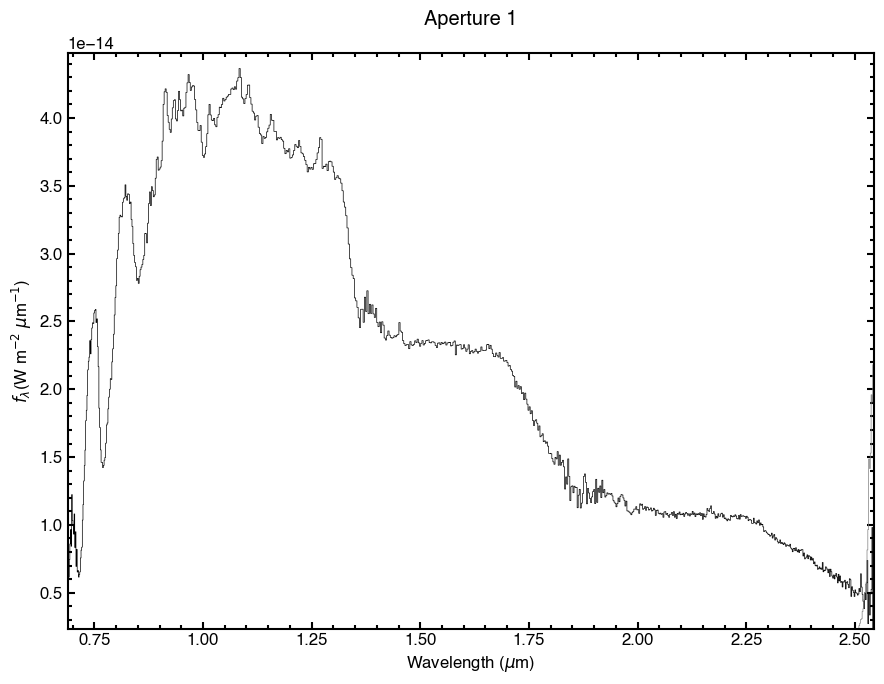

In [11]:
# plot with default parameters
from pyspextool.plot.plot_spectra import plot_spectra

file = 'calspec1-2.fits'
ax = plot_spectra(proc+file,colors='k', ytype="flux and uncertainty", order_numbers=False)